# Feature extraction using VGG16

In [1]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2023-04-19 14:30:31.018435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plotting function (from last week)

In [2]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Initialize the model

In [3]:
# load the model
model = VGG16()

__Preprocessing__

Keras provides some tools to help with this step.

First, we can use the ```load_img()``` function to load the image and resize it to the required size of 224×224 pixels.

In [4]:
# load an image from file
# taget size shapes the image to that size no matter the original
image = load_img('../data/img/florence.jpg', target_size=(224, 224))

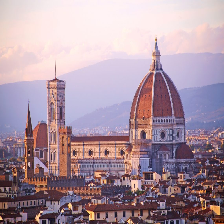

In [5]:
image

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. 

We can use the ```img_to_array()``` function for this.

In [6]:
# convert the image pixels to a numpy array
image = img_to_array(image)

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling ```reshape()``` and adding the extra dimension.

In [7]:
# reshape data for the model
# takes the 3D to 4D by adding an extra dimension we call 1
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. Specifically, from the paper:

>The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. 

See the paper [here](https://arxiv.org/abs/1409.1556).

In [8]:
# prepare the image for the VGG model
image = preprocess_input(image)

## Make prediction using ImageNet labels

We then use the model to predict our image class and convert probabilities to class labels using ```decode_predictions()```.

In [9]:
# predict the probability across all output classes
y_pred = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(y_pred)

1/1 [==============================] - 1s 962ms/step


__Inspect most likely label__

In [10]:
# show the five most likely predictions
label

[[('n03220513', 'dome', 0.4570255),
  ('n03028079', 'church', 0.3018246),
  ('n03877845', 'palace', 0.04829815),
  ('n02930766', 'cab', 0.026109071),
  ('n02825657', 'bell_cote', 0.024095394)]]

## Finetune on new task

We import the regular cifar10 dataset from ```keras``` and normalise.

In [11]:
# import dataset and normalise by dividing by 255
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()
X_train = X_train.astype("float") / 255.
X_test = X_test.astype("float") / 255.

__Binarize labels__

In [12]:
# integers to one-hot vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# initialize label names for CIFAR-10 dataset
labelNames = ["airplane", "automobile", 
              "bird", "cat", 
              "deer", "dog", 
              "frog", "horse", 
              "ship", "truck"]

__Check tensor shape__

In [13]:
# checking shape
# 50000 images that are 32*32
X_train.shape

(50000, 32, 32, 3)

__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [14]:
# load model without classifier layers
model = VGG16(include_top=False, # this removes the final classification network
              pooling='avg', # put an average pooling layer in the top instead
              input_shape=(32, 32, 3)) # changing input shape to the predefined shape of the data

__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

It would othervise update all the weights, which we want to keep since they have already been trained.

In [15]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [17]:
tf.keras.backend.clear_session()

In [18]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) # flattens the layer based on the old model
class1 = Dense(128, activation='relu')(flat1) # adding first classification layer
output = Dense(10, activation='softmax')(class1) # prediction layer

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [19]:
# chaning the learning rates depending on where it is in the steps
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9) # over time slow down how quickly it is learning by the power of 0.9

sgd = SGD(learning_rate=lr_schedule)

In [20]:
# 
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [21]:
# fitting the model to training data and training label
H = model.fit(X_train, y_train, 
            validation_split=0.1, # 10% of the data
            batch_size=128, 
            epochs=10,
            verbose=1)

Epoch 1/10
 14/352 [>.............................] - ETA: 4:57 - loss: 2.3489 - accuracy: 0.1032

KeyboardInterrupt: 

__Evaluate__

In [ ]:
# the plots shows that the data may not the too representable, but it is acceptable
plot_history(H, 10)

In [ ]:
# showing predictions
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

## Using data augmentation

__Reload model__

In [ ]:
# reloading model
del model
tf.keras.backend.clear_session()

In [1]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)
class1 = Dense(256, 
               activation='relu')(bn)
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(10, 
               activation='softmax')(class2)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# summarize
model.summary()

NameError: name 'VGG16' is not defined

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
# flip along x axis (mirror image)
datagen = ImageDataGenerator(horizontal_flip=True, # flipping the image
                             rotation_range=20, # how many degrees we whant to rotate the image
                             validation_split=0.1) # 10% of the data is validation data

We're choosing to generate data on the fly, rather than save it to a folder.

__Train__

In [ ]:
# fit the data generator to our images
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(X_train, y_train, batch_size=128), 
              validation_data = datagen.flow(X_train, y_train, batch_size=128, subset = "validation"),
            epochs=10)

Epoch 1/10


2023-04-14 13:45:40.386299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  7/391 [..............................] - ETA: 4:09 - loss: 2.5406 - accuracy: 0.1071

KeyboardInterrupt: 

__Inspect__

In [ ]:
plot_history(H, 10)

__Evaluate__

In [ ]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))